# Mexico Property Prices

## 1. Problem statement
- This project is aimed at predicting apartment prices in Mexico City with the aid of 14 features which includes surface_total_in_m2, lat-lon, price_per_m2 and rooms.

## 2. Data Collection

### 2.1: Data Source and Description
- Dataset Source - https://github.com/tuancompa2610/Predict-Mexico-House-Price
- The data consists of of 5 comma seperated files which when combined results in 16 columns and 23,140 rows.

### 2.2: Import data and required packages

In [1]:
import warnings

from glob import glob
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import gzip
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

### 2.3: Dataset information

In [2]:
# Use glob to create a list of filenames for all the Mexico City real estate CSV files
files = glob("./data/mexico-city-real-estate-[0-5].csv")

# Define function that takes a file path as an argument and returns a DataFrame
def read(filepath):
    df = pd.read_csv(filepath)
    return df

# Use function to create a list named frames
frames = [read(path) for path in files]

# Concatenate the items in frames into a single DataFrame df and reindex
df = pd.concat(frames)

print("Shape of df:", df.shape)
df.head()

Shape of df: (23140, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851900,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481480,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


### 2.4: Preprocess data

In [3]:
# Extract "borough" and "district" from "place_with_parent_names"
parent_names = df["place_with_parent_names"].str.split("|", expand=True)
df["borough"] = parent_names[1]
df["district"] = parent_names[2]
df.drop(columns="place_with_parent_names", inplace=True)

# Include only properties in "Distrito Federal"
df = df[df["district"] == "Distrito Federal"]

# Split "lat-lon" column
df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
df.drop(columns="lat-lon", inplace=True) 

# Remove columns price, currency, price_aprox_local_currency
df.drop(columns=['price', 'currency', 'price_aprox_local_currency'], inplace=True)

print("df shape:", df.shape)

df shape: (18942, 15)


## 3. Data Checks

### 3.1: Check missing values

In [4]:
# Sum of all missing values
df.isnull().sum()

operation                    0
property_type                0
price_aprox_usd            363
surface_total_in_m2      13506
surface_covered_in_m2      811
price_usd_per_m2         15175
price_per_m2              1366
floor                    18304
rooms                    18448
expenses                 18931
properati_url                0
borough                      0
district                     0
lat                       1932
lon                       1932
dtype: int64

### 3.2: Remove columns with high missing values

In [5]:
# Extract columns having missing values with more than halve the data
col_miss = [col for col in df.columns if df[col].isnull().sum() > df.shape[0]/2]
print(col_miss)

['surface_total_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses']


In [6]:
# Use col_miss to remove columns from df
df.drop(columns=col_miss, inplace=True)
df.columns

Index(['operation', 'property_type', 'price_aprox_usd',
       'surface_covered_in_m2', 'price_per_m2', 'properati_url', 'borough',
       'district', 'lat', 'lon'],
      dtype='object')

In [7]:
# Check missing values again
df.isnull().sum()

operation                   0
property_type               0
price_aprox_usd           363
surface_covered_in_m2     811
price_per_m2             1366
properati_url               0
borough                     0
district                    0
lat                      1932
lon                      1932
dtype: int64

In [8]:
# Remove rows by using missing values in price_aprox_usd column
df.dropna(subset=['price_aprox_usd'], inplace=True)

In [9]:
# Check missing values again
print(df.isnull().sum())
df.shape

operation                   0
property_type               0
price_aprox_usd             0
surface_covered_in_m2     808
price_per_m2             1003
properati_url               0
borough                     0
district                    0
lat                      1849
lon                      1849
dtype: int64


(18579, 10)

### 3.3: Check duplicates

In [10]:
# Toal duplicates
df.duplicated().sum()

0

### There are no duplicates to remove

### 3.4: Check data types

In [11]:
# Information of data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18579 entries, 0 to 4627
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   operation              18579 non-null  object 
 1   property_type          18579 non-null  object 
 2   price_aprox_usd        18579 non-null  float64
 3   surface_covered_in_m2  17771 non-null  float64
 4   price_per_m2           17576 non-null  float64
 5   properati_url          18579 non-null  object 
 6   borough                18579 non-null  object 
 7   district               18579 non-null  object 
 8   lat                    16730 non-null  float64
 9   lon                    16730 non-null  float64
dtypes: float64(5), object(5)
memory usage: 1.6+ MB


### 3.5: Check unique values in object columns

In [12]:
# Define dataframe object columns
obj_col = df.select_dtypes(exclude="number").columns
df[obj_col].nunique()

operation            1
property_type        4
properati_url    18579
borough             16
district             1
dtype: int64

### 3.6: Remove object columns with high dimensionality

In [13]:
# Extract object columns with dimensionality not between 2 and 99
col_dim = [col for col in obj_col if df[col].nunique() not in range(2,99)]
print(col_dim)

['operation', 'properati_url', 'district']


In [14]:
# Remove high dimentionality columns from df
df.drop(columns=col_dim, inplace=True)
df.shape

(18579, 7)

In [15]:
# Define fuction to keep object value_counts more than 20

def keep_value(df_in, col_name): 
    
    # Explore the borough column
    col_count = df_in[col_name].value_counts()

    # Extract the index of borough_count 
    col_ind = col_count.index

    # Create zip object with borough_ind and borough_count
    zipper = list(zip(col_ind, col_count))

    # Subset borough values more than 20
    col_less = [val[0] for val in zipper if val[1] > 20]

    # get new df with borough_less
    df_out = df_in[df_in[col_name].isin(col_less)]
    
    return df_out

In [16]:
# Keep value_counts of 'borough' more than 20
df = keep_value(df, 'borough')
df.shape

(18577, 7)

In [17]:
# Keep value_counts of 'property_type' more than 20
df = keep_value(df, 'property_type')
df.shape

(18563, 7)

### 3.7: Check statistics

In [18]:
# Get the description of the dataframe
num_col = df.select_dtypes(include="number").columns
df[num_col].describe().round(1)

,price_aprox_usd,surface_covered_in_m2,price_per_m2,lat,lon
count,18563.0,17769.0,17574.0,16715.0,16715.0
mean,271767.3,4136.0,24308.6,19.5,-99.2
std,513897.1,493603.1,40706.7,0.6,0.5
min,5796.9,0.0,0.0,19.2,-102.6
25%,59040.4,65.0,11444.4,19.3,-99.2
50%,120652.0,91.0,18488.4,19.4,-99.2
75%,252419.7,200.0,32209.5,19.4,-99.1
max,17890000.0,65748000.0,3338952.9,41.6,-90.5


### 3.8: Check correletion

In [19]:
corr = df[num_col].drop(columns="price_aprox_usd").corr()
corr

,surface_covered_in_m2,price_per_m2,lat,lon
surface_covered_in_m2,1.000000,-0.004856,-0.001787,0.002450
price_per_m2,-0.004856,1.000000,0.053367,-0.049915
lat,-0.001787,0.053367,1.000000,-0.891294
lon,0.002450,-0.049915,-0.891294,1.000000


### 3.9: Draw the correlation heatmap

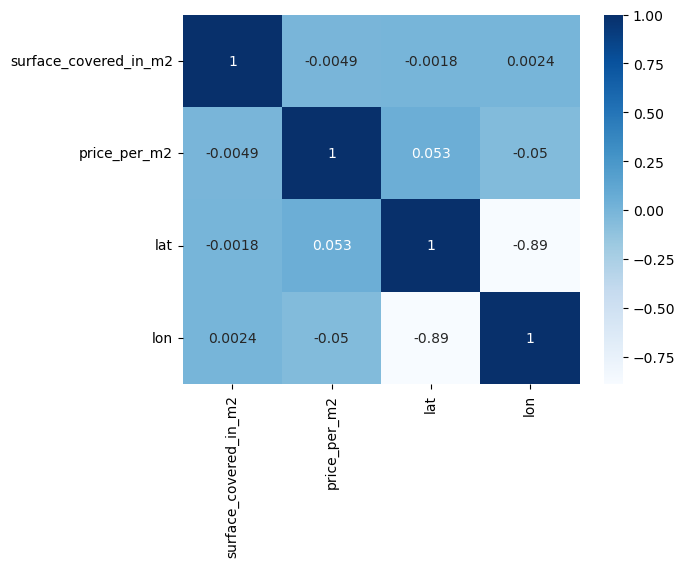

In [20]:
sns.heatmap(corr, cmap='Blues', annot=True);

### There are no colinear columns

### 3.8: Check outliers

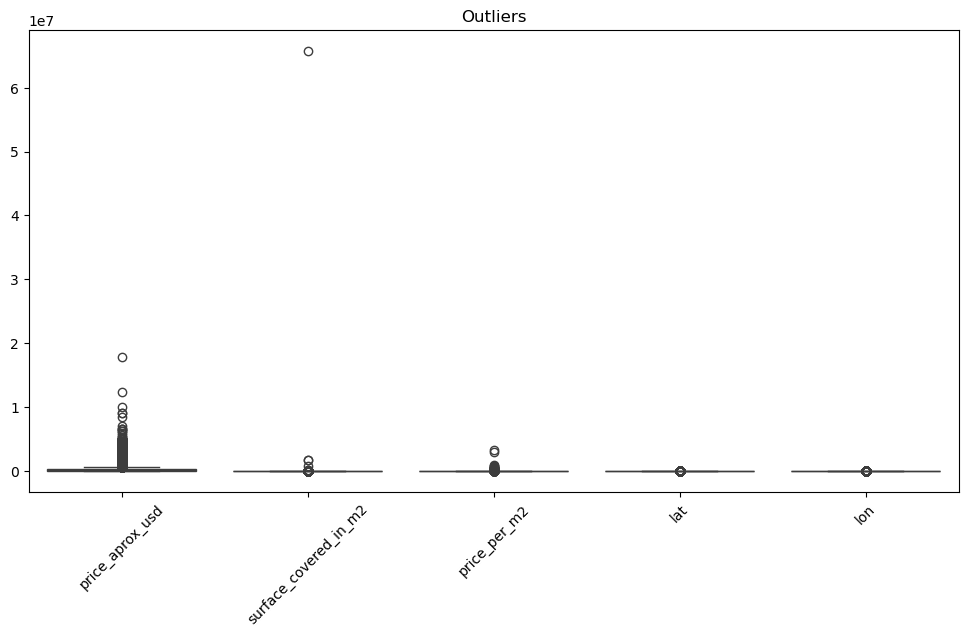

In [21]:
# Create box plot for the numerical columns
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)
plt.title('Outliers')
sns.boxplot(data=df);

### 3.9 Remove outliers

In [22]:
# Function to remove_outlier
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1
    lower  = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    df_remove = df_in[~((df_in[col_name] < lower) | (df_in[col_name] > upper))]
    return df_remove

# Function to get_outlier
def extract_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1
    lower  = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    df_extract = df_in[((df_in[col_name] < lower) | (df_in[col_name] > upper))]
    return df_extract

# Function to replace_outlier with NaN
def nan_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1
    lower  = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    df_nan = df_in.replace(((df_in[col_name] < lower) | (df_in[col_name] > upper)), np.nan)
    return df_nan

# Function to replace_outlier with median
def median_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1
    lower  = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    df_median = df_in.replace(((df_in[col_name] < lower) | (df_in[col_name] > upper)), df_in[col_name].median())
    return df_median

In [23]:
# Remove rows using outliers in price_aprox_usd column
df = remove_outlier(df, 'price_aprox_usd')
print(df.shape)
df.head()

(16426, 7)


,property_type,price_aprox_usd,surface_covered_in_m2,price_per_m2,borough,lat,lon
0,apartment,289775.66,54.0,101851.85190,Miguel Hidalgo,23.634501,-102.552788
1,house,79661.96,80.0,18900.00000,Iztapalapa,19.310330,-99.068557
2,apartment,48822.82,100.0,9266.67000,Tlalpan,19.279771,-99.234597
3,apartment,337720.36,135.0,47481.48148,Miguel Hidalgo,23.634501,-102.552788
5,apartment,232663.51,87.0,50758.62069,Miguel Hidalgo,19.432657,-99.177444


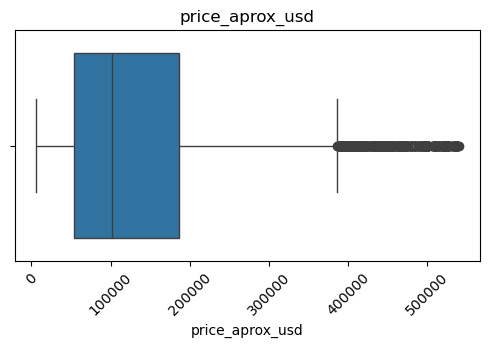

In [24]:
# Create box plot for the numerical price_aprox_usd
plt.figure(figsize=(6, 3))
plt.xticks(rotation=45)
plt.title('price_aprox_usd')
sns.boxplot(x=df['price_aprox_usd']);

### 3.10: Rearrange columms in df

In [25]:
# Define object columns
df_obj = df.select_dtypes(exclude="number").columns.to_list()
df_obj

['property_type', 'borough']

In [26]:
# Define number columns
df_num = df.select_dtypes(include="number").columns.to_list()
df_num

['price_aprox_usd', 'surface_covered_in_m2', 'price_per_m2', 'lat', 'lon']

In [27]:
# Rearrange df with object columns coming first
df = df[['property_type', 'borough', 'surface_covered_in_m2', 'price_per_m2', 'lat', 'lon', 'price_aprox_usd']]
print(df.shape)
df.head()

(16426, 7)


,property_type,borough,surface_covered_in_m2,price_per_m2,lat,lon,price_aprox_usd
0,apartment,Miguel Hidalgo,54.0,101851.85190,23.634501,-102.552788,289775.66
1,house,Iztapalapa,80.0,18900.00000,19.310330,-99.068557,79661.96
2,apartment,Tlalpan,100.0,9266.67000,19.279771,-99.234597,48822.82
3,apartment,Miguel Hidalgo,135.0,47481.48148,23.634501,-102.552788,337720.36
5,apartment,Miguel Hidalgo,87.0,50758.62069,19.432657,-99.177444,232663.51


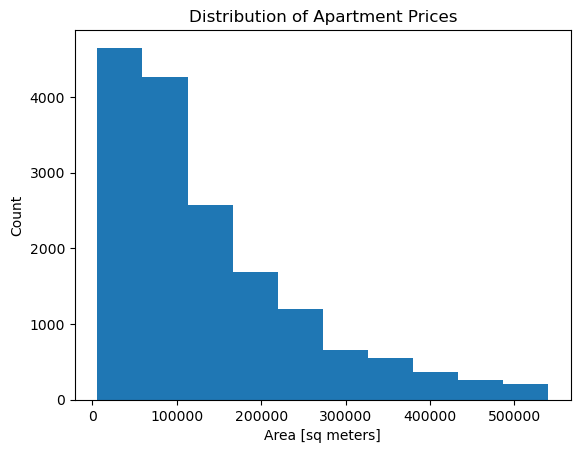

In [28]:
# Plot distribution of price
plt.hist(df["price_aprox_usd"])
plt.title("Distribution of Apartment Prices")
plt.xlabel("Area [sq meters]")
plt.ylabel("Count");

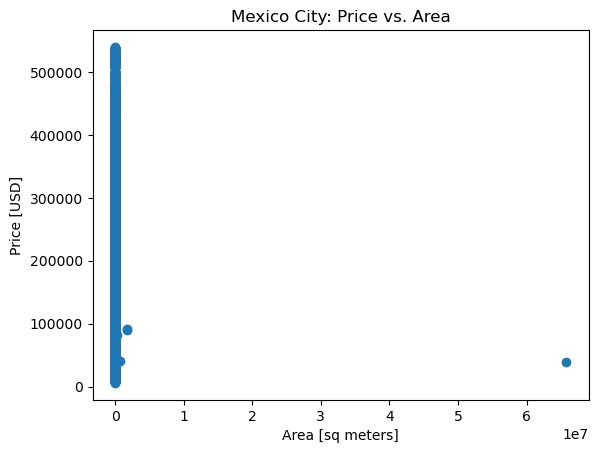

In [29]:
# Plot price vs area
plt.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Mexico City: Price vs. Area");

### 3.11: Evaluate model with outlier removal and outlier substitution

In [30]:
# Define columns with outliers
out_col = ['surface_covered_in_m2', 'price_per_m2', 'lat', 'lon']

In [31]:
# Calculate total outliers
for col in out_col:
    df_ex = extract_outlier(df, col)
    
print('Percent of outliers = ' + str(round(df_ex.shape[0]*100/16437)) + '%')

Percent of outliers = 5%


## 4. Train model

### 4.1: Function to train model

In [32]:
# Create function that trains df

def train_df(df):
    
    # Prepare X and Y variables
    X = df.drop(columns=['price_aprox_usd'], axis=1)
    y = df['price_aprox_usd']

    # Subset categorical and numerical columns
    num_features = X.select_dtypes(include="number").columns.to_list()
    cat_features = X.select_dtypes(exclude="number").columns.to_list()

    # Create the preprocessor.
    num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
    cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OrdinalEncoder())

    preprocessor = make_column_transformer(
        (num_pipeline, num_features),
        (cat_pipeline, cat_features)
    )

    # Separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create function to give all metrics after model rraining
    def evaluate_model(true, predicted):
        mae = mean_absolute_error(true, predicted)
        mse = mean_squared_error(true, predicted)
        rmse = np.sqrt(mean_squared_error(true, predicted))
        r2_square = r2_score(true, predicted)
        return mae, rmse, r2_square

    # Use function to evaluate models
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso": Lasso(),
        "Ridge": Ridge(),
        "K-Neighbors Regressor": KNeighborsRegressor(),
        "Decision Tree": DecisionTreeRegressor(),
        "Random Forest Regressor": RandomForestRegressor(),
        "XGBRegressor": XGBRegressor(), 
        "CatBoosting Regressor": CatBoostRegressor(verbose=False),
        "AdaBoost Regressor": AdaBoostRegressor()
    }

    # Create model and r2_square empty lists
    model_list = []
    r2_list = []

    # Run the models
    for i in range(len(list(models))):
        selected = list(models.values())[i]
        model = make_pipeline(preprocessor, selected)
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Evaluate Train and Test dataset
        model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
        model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
        
        # Append to model and r2_square empty lists
        model_list.append(list(models.keys())[i])
        r2_list.append(model_test_r2)

    # Create a dataframe of the results
    df_result = pd.DataFrame(list(zip(model_list, r2_list)), \
                             columns=['Model Name', 'R2_Score']).\
                             sort_values(by=["R2_Score"],ascending=False)

    return df_result

### 4.2: Evalutate trained model

In [33]:
# Remove outliers from df
for col in out_col:
    df_rem = remove_outlier(df, col).reset_index(drop=True)

# Train df with outliers removed
train_df(df_rem)

,Model Name,R2_Score
5,Random Forest Regressor,0.969936
7,CatBoosting Regressor,0.967547
6,XGBRegressor,0.963092
4,Decision Tree,0.962439
3,K-Neighbors Regressor,0.633574
8,AdaBoost Regressor,0.582817
0,Linear Regression,0.350408
1,Lasso,0.350404
2,Ridge,0.350390


In [34]:
# Replace outliers with NaN
for col in out_col:
    df_nan = nan_outlier(df, col).reset_index(drop=True)

# Train df with outliers replaced with NaN
train_df(df_nan)

,Model Name,R2_Score
7,CatBoosting Regressor,0.964041
6,XGBRegressor,0.957878
5,Random Forest Regressor,0.952106
4,Decision Tree,0.922488
3,K-Neighbors Regressor,0.630307
8,AdaBoost Regressor,0.503132
1,Lasso,0.124865
2,Ridge,0.124712
0,Linear Regression,0.124662


In [35]:
# Replace outliers with median
for col in out_col:
    df_med = median_outlier(df, col).reset_index(drop=True)

# Train df with outliers replaced with median
train_df(df_med)

,Model Name,R2_Score
7,CatBoosting Regressor,0.964041
6,XGBRegressor,0.957878
5,Random Forest Regressor,0.952824
4,Decision Tree,0.925151
3,K-Neighbors Regressor,0.630307
8,AdaBoost Regressor,0.487237
1,Lasso,0.124865
2,Ridge,0.124712
0,Linear Regression,0.124662


### The best result was achieved when outliers were removed with Random Forest Regressor model

### 4.3: Save dataframe to data folder

In [36]:
# Save df_rem
df_rem.to_parquet('./data/mexico_data.parquet', compression='gzip')

In [37]:
# Get the columns of df_rem
df_rem.columns.to_list()

['property_type',
 'borough',
 'surface_covered_in_m2',
 'price_per_m2',
 'lat',
 'lon',
 'price_aprox_usd']

## 5. Train selected algorithm with GridSearchCV

In [38]:
# Import dataframe
df = pd.read_parquet('./data/mexico_data.parquet')

# Prepare X and Y variables
X = df.drop(columns=['price_aprox_usd'], axis=1)
y = df['price_aprox_usd']

# Subset categorical and numerical columns
num_features = X.select_dtypes(include="number").columns.to_list()
cat_features = X.select_dtypes(exclude="number").columns.to_list()


# Create the preprocessor.
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OrdinalEncoder())

preprocessor = make_column_transformer(
    (num_pipeline, num_features),
    (cat_pipeline, cat_features)
)


# Separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define estimator
estimator = make_pipeline(preprocessor, RandomForestRegressor())

# Define parameter range
param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__min_samples_split': [2, 3, 5], 
    'randomforestregressor__min_samples_leaf': [1, 2, 3]
}

# Define model
grid = GridSearchCV(
    estimator=estimator, 
    param_grid=param_grid,
    cv=5, 
    n_jobs=-1
) 
   
# Fit model for grid search 
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['surface_covered_in_m2',
                                                                          'price_per_m2',
                                                                          'lat',
                                                                          'lon']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['property_type',
                                                                          'borough'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__min_samples_leaf': [1, 2, 3],
                         'randomforestregressor__min_samples_split': [2, 3, 5],
                         'randomforestregressor__n_estimators': [100, 200,
                                                                 300]})

In [39]:
# Calculate predictions
predictions = grid.predict(X_test)
 
# Print best parameter after tuning 
print(f'{grid.best_params_}\n')

# Print r2_square
print(f'{r2_score(y_test, predictions):.4f}')

{'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100}

0.9691


## Save and load model

In [40]:
# Save the model to disk
pickle.dump(grid, gzip.open('mexico_model.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
# load the model from disk
loaded_model = pickle.load(gzip.open('mexico_model.pkl', 'rb'))

## Use the model for some predictions

In [42]:
# Create function to predict the raw data
def predict_data(raw_data):
    data_frame = pd.DataFrame(raw_data, index=[0])
    data_predict = loaded_model.predict(data_frame)
    return data_predict[0]

In [43]:
# Get the sample data to use.
sample_data = df.loc[1404]
sample_data

property_type                  store
borough                   Cuauhtémoc
surface_covered_in_m2          355.0
price_per_m2             14464.78873
lat                        19.405168
lon                       -99.142608
price_aprox_usd            270545.09
Name: 1404, dtype: object

In [44]:
# Define raw data
raw_data = {
    "property_type": sample_data.loc['property_type'],
    "borough": sample_data.loc['borough'],
    "surface_covered_in_m2": sample_data.loc['surface_covered_in_m2'],
    "price_per_m2": sample_data.loc['price_per_m2'],
    "lat": sample_data.loc['lat'],
    "lon": sample_data.loc['lon']
}

raw_data

{'property_type': 'store',
 'borough': 'Cuauhtémoc',
 'surface_covered_in_m2': 355.0,
 'price_per_m2': 14464.78873,
 'lat': 19.405168,
 'lon': -99.142608}

In [45]:
# Compute prediction
prediction = predict_data(raw_data).round(2)
prediction

271105.66

In [46]:
# Get the sample data to use.
sample_data = df.loc[1234]
sample_data

property_type                 apartment
borough                  Miguel Hidalgo
surface_covered_in_m2              75.0
price_per_m2                8977.773333
lat                           19.455894
lon                           -99.18355
price_aprox_usd                35483.96
Name: 1234, dtype: object

In [47]:
# Define raw data
raw_data = {
    "property_type": sample_data.loc['property_type'],
    "borough": sample_data.loc['borough'],
    "surface_covered_in_m2": sample_data.loc['surface_covered_in_m2'],
    "price_per_m2": sample_data.loc['price_per_m2'],
    "lat": sample_data.loc['lat'],
    "lon": sample_data.loc['lon']
}

raw_data

{'property_type': 'apartment',
 'borough': 'Miguel Hidalgo',
 'surface_covered_in_m2': 75.0,
 'price_per_m2': 8977.773333,
 'lat': 19.455894,
 'lon': -99.18355}

In [48]:
# Compute prediction
prediction = predict_data(raw_data).round(2)
prediction

35499.13

In [49]:
# Get the sample data to use.
sample_data = df.loc[15555]
sample_data

property_type                house
borough                    Tlalpan
surface_covered_in_m2        100.0
price_per_m2               28700.0
lat                      19.293674
lon                     -99.108352
price_aprox_usd           151210.2
Name: 15555, dtype: object

In [50]:
# Define raw data
raw_data = {
    "property_type": sample_data.loc['property_type'],
    "borough": sample_data.loc['borough'],
    "surface_covered_in_m2": sample_data.loc['surface_covered_in_m2'],
    "price_per_m2": sample_data.loc['price_per_m2'],
    "lat": sample_data.loc['lat'],
    "lon": sample_data.loc['lon']
}

raw_data

{'property_type': 'house',
 'borough': 'Tlalpan',
 'surface_covered_in_m2': 100.0,
 'price_per_m2': 28700.0,
 'lat': 19.293674,
 'lon': -99.108352}

In [51]:
# Compute prediction
prediction = predict_data(raw_data).round(2)
prediction

151247.08